In [ ]:
# -- 필요한 라이브러리 설치 --
!pip install transformers
!pip install Keras-Preprocessing

In [2]:
import pandas as pd
import torch
from transformers import ElectraForSequenceClassification, AutoTokenizer, AdamW, ElectraTokenizer
# from transformers import DistilBertTokenizer, DistilBertModel
from transformers import get_linear_schedule_with_warmup
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import random
import numpy as np
from sklearn.metrics import classification_report

# GPU 사용
device = torch.device("cuda")

In [3]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/nv_bj_one.csv')
df['id'] = df['id'].astype(str)
df['cat_id'] = df['cat_id'].astype(str)
df.head()

,id,name,cat_id
0,38241346937-310300400,쟈딕앤볼테르 Kayak 카키 아모르 카모 레터링 프린트 야상 자켓 점퍼,310300400
1,39945841940-310300400,카인 후드 바람막이 점퍼,310300400
2,40085020674-310300400,데이나믹 툴린스 고어텍스 여자 후드 윈드브레이커 자켓 20897733 1A00008...,310300400
3,38856225697-310300400,ZOOC 반팔 데님자켓 Z222PSF403 1544239,310300400
4,83356850408-310300400,봄 오버핏 힙합 점퍼 가을 데님 여성 재킷 야상 스트릿 아우터 여자 야구 학생,310300400


In [4]:
# -- preprocessing --

def split_data(df):
    # format changes
    df['name'] = "[CLS] " + df['name'] + " [SEP]"

    # encoding
    encoder = LabelEncoder()
    df['label'] = encoder.fit_transform(df['cat_id']) # sub

    # train, test dataset split
    train_x, test_x, train_y, test_y = train_test_split(df['name'], df['label'].values, random_state=42, test_size=0.2)
    train_df, test_df = df.loc[train_x.index], df.loc[test_x.index]
    return train_df, test_df

train_df, test_df = split_data(df)

In [5]:
# -- converting inputs --
def convert_input(sentences):
    tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator")
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
    max_len = 200
    input_ids = [tokenizer.convert_tokens_to_ids(text) for text in tokenized_texts]
    input_ids = pad_sequences(input_ids, maxlen=max_len, dtype="long", truncating="post", padding="post")
    attention_masks = []
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return input_ids, attention_masks

input_ids, attention_masks = convert_input(train_df['name'])

In [6]:
# -- train and validation set --
def split_train_and_validation(input_ids, attention_masks):
    train_x, val_x, train_y, val_y = train_test_split(input_ids, train_df['label'].values, random_state=5, test_size=.2)
    train_mask, val_mask, _, _ = train_test_split(attention_masks, input_ids, random_state=5, test_size=.2)

    # tensor로 만들기
    train_x = torch.tensor(train_x)
    train_y = torch.tensor(train_y)
    train_mask = torch.tensor(train_mask)

    val_x = torch.tensor(val_x)
    val_y = torch.tensor(val_y)
    val_mask = torch.tensor(val_mask)

    # dataloader
    batch_size = 32
    train_data = TensorDataset(train_x, train_mask, train_y)
    train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=batch_size)

    val_data = TensorDataset(val_x, val_mask, val_y)
    val_dataloader = DataLoader(val_data, sampler=SequentialSampler(val_data), batch_size=batch_size)

    return train_dataloader, val_dataloader

train_dataloader, val_dataloader = split_train_and_validation(input_ids, attention_masks)

In [7]:
# -- setting device --
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-16GB


In [8]:
# -- koelectra_v3_small --
model = ElectraForSequenceClassification.from_pretrained("monologg/koelectra-base-v3-discriminator",
                                                         num_labels=df['cat_id'].nunique()
                                                         )
model.cuda()

epochs = 10
total_steps = len(train_dataloader) * epochs

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# 처음에 학습률을 조금씩 변화시키는 스케줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

Some weights of the model checkpoint at monologg/koelectra-base-v3-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-v3-discriminator and are newly initialized: 

In [9]:
from sklearn.metrics import accuracy_score
# -- model training --
# 시드 설정
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


# 그래디언트 초기화
model.zero_grad()
loss_list, acc_list = [], []
for epoch in tqdm(range(0, epochs)):
    # 로스 초기화
    total_loss = 0
    # 훈련모드
    model.train()
    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch
        # Forward 수행
        outputs = model(input_ids= b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        total_loss += loss.item()
        # Backward 수행으로 그래디언트 계산
        loss.backward()
        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()
        # 스케줄러로 학습률 감소
        scheduler.step()
        # 그래디언트 초기화
        model.zero_grad()
    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)
    loss_list.append(avg_train_loss)

    # 평가모드
    model.eval()
    # 변수 초기화
    eval_loss, eval_accuracy, nb_eval_steps = 0, 0, 0
    for batch in val_dataloader:
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch
        # 그래디언트 계산 안함
        with torch.no_grad():
            # Forward 수행
            outputs = model(input_ids=b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask)
            # 로스 구함
        logits = outputs.logits
        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # calculate accuracy based on top 3 labels predicted
        predictions = np.argsort(logits, axis=1)[:, -3:]  # Get indices of top 3 labels
        accuracy = np.mean([1 if label in pred else 0 for label, pred in zip(label_ids, predictions)])
        eval_accuracy += accuracy

        nb_eval_steps += 1

    acc_list.append(round(eval_accuracy / nb_eval_steps, 2))

  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

Accuracy : 0.9474


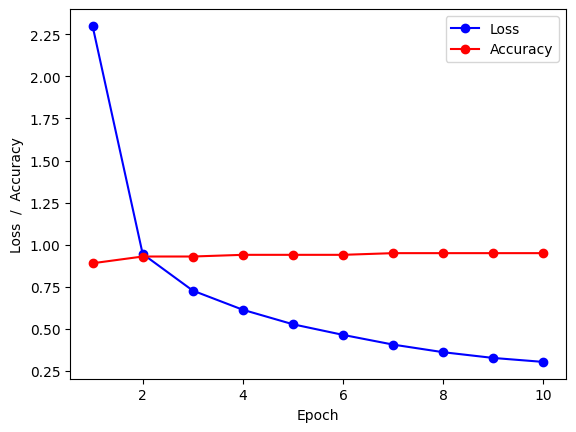

In [ ]:
# -- sub category loss and accuracy with top 3 labels --
epoch = range(1, epochs+1)
plt.plot(epoch, loss_list,'-bo', label='Loss')
plt.plot(epoch, acc_list, '-ro', label='Accuracy')
plt.legend(), plt.xlabel('Epoch'), plt.ylabel('Loss  /  Accuracy');
print(f'Accuracy : {round(eval_accuracy/nb_eval_steps, 4)}')

In [ ]:
# 모델 저장
PATH = '/content/drive/MyDrive/'
torch.save(model, PATH + 'koelectra_base_model_v2.pt')  # 전체 모델 저장
torch.save(model.state_dict(), PATH + 'koelectra_base_model_state_dict_v2.pt')  # 모델 객체의 state_dict 저장
torch.save({'model': model.state_dict(), 'optimizer': optimizer.state_dict()}, PATH + 'koelectra_base_all_v2.tar')

# 나라님께서 api에서 적용가능한 부분 (아래)

In [ ]:
# --- 전이 학습 ---------------------------------

In [ ]:
# -- 필요한 라이브러리 설치 --
!pip install transformers
!pip install Keras-Preprocessing

In [ ]:
import pandas as pd
import torch
from transformers import ElectraForSequenceClassification, AutoTokenizer, AdamW, ElectraTokenizer
from transformers import get_linear_schedule_with_warmup
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import random
import numpy as np
from sklearn.metrics import classification_report

# GPU 활성화 코드
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count()) # 있는지 없는지
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
# 필요 파일
# 1. koelectra_base_model.pt
# 2. koelectra_base_model_state_dict.pt
# 3. koelectra_base_all.tar

# 모델 다운로드
PATH = '/content/drive/MyDrive/'
model = torch.load(PATH + 'koelectra_base_model_v2.pt')  # 모델 불러오기
model.load_state_dict(torch.load('/content/drive/MyDrive/koelectra_base_model_state_dict_v2.pt'))
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8)

checkpoint = torch.load(PATH + 'koelectra_base_all_v2.tar')   # dict 불러오기
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])

In [ ]:
# 3개 레이블 예측해주는 함수.
def test_sentences(sentences):
    model.eval()
    # 문장을 입력 데이터로 변환
    input_ids, attention_masks = convert_input(sentences)
    # 데이터를 파이토치의 텐서로 변환
    inputs = torch.tensor(input_ids)
    masks = torch.tensor(attention_masks)
    # 데이터를 GPU에 넣음
    b_input_ids = inputs.to(device)
    b_input_mask = masks.to(device)
    # 그래디언트 계산 안함
    with torch.no_grad():
        outputs = model(input_ids=b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask)
    logits = outputs.logits
    logits = logits.detach().cpu().numpy()

    predictions = np.argsort(logits, axis=1)[:, -3:]  # Get indices of top 3 labels

    return predictions

# input 변환 함수 (위의 함수가 돌아갈 수 있도록 상품명 변환)
def convert_input(sentences):
    tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator")
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
    max_len = 200
    input_ids = [tokenizer.convert_tokens_to_ids(text) for text in tokenized_texts]
    input_ids = pad_sequences(input_ids, maxlen=max_len, dtype="long", truncating="post", padding="post")
    attention_masks = []
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return input_ids, attention_masks

In [ ]:
test_df = test_df.reset_index(drop=True)
test_df.head()

,id,name,cat_id,label,predicted
0,82142717842-320210400,[CLS] [CLS] [CLS] 티뷰크 남성 스트라이프 셔츠 TB1912 [SEP]...,320210400,46,NaN
1,222822763,[CLS] [CLS] [CLS] 세련된 실버 뱅글 링팔찌 [SEP] [SEP] [SEP],422300200,114,NaN
2,39290864034-310260600,[CLS] [CLS] [CLS] 숏클립할인 플랜 하트 프린팅 여유핏 숏 맨투맨티 E...,310260600,23,NaN
3,40621696240-320160800,[CLS] [CLS] [CLS] 남성 깅엄 체크 순면 잠옷 세트 홈웨어 파자마 사계...,320160800,40,NaN
4,35634428043-405300200,[CLS] [CLS] [CLS] 남성워커 남자 군화 전투화 패브릭 부츠 워커 사막화...,405300200,81,NaN


In [ ]:
# test data에 적용

# -- 데이터 한개에 대하여 예측을 할지 혹은 여러 데이터 (데이터 프레임)에 대해서 예측할지에 따라 --
# -- 코드가 좀 달라질 수 있어요 --

# 1. 데이터 프레임일 때

# pd.read_csv() 블라블라
# 여기서는 test_df
# label
for idx in tqdm(range(len(test_df))):
    preds = test_sentences([test_df.name[idx]])
    top_labels = ' '.join(str(label) for label in preds[0])
    test_df.at[idx, 'predicted'] = top_labels

test_df

In [ ]:
# 정확도 구하기 (api에 꼭 필요한 부분은 아님)
# 변환 전의 cat_id -> 위의 과정에서 inverse_transform이 필요!
accuracy = 0
for idx in tqdm(range(len(test_df))):
    # -- 여기 코드 변경 필요 --
    if str(test_df.loc[idx, 'label']) in test_df.loc[idx, 'predicted'].split(' '): # 띄어쓰기로 split
        accuracy += 1
print(accuracy / len(test_df))

In [ ]:
# 2. input이 하나일 때
# S급 풀구성 구찌 스네이크 카드지갑(Black)

product_name = 'S급 풀구성 구찌 스네이크 카드지갑(Black)' # 예시
preds = test_sentences([product_name]) # [] 괄호 꼭 필요해요!
print(preds) # 결괏값 예시


[[154 156 155]]


In [ ]:
# 결괏값 변환 필요 -> 원래 cat_id 값으로

encoder.inverse_transform([154, 156, 155]) # 결괏값 object

array(['430400', '430999', '430500'], dtype=object)

In [ ]:
# cat_id 전체
cat_id_list = ['310300200', '310300100', '310300300', '310300400', '310300600', '310300500', '310260800',
 '310260700', '310260600', '310260500', '310260400', '310260100', '310260200', '310260300',
 '310150080', '310150010', '310150030', '310150090', '310150040', '310150070', '310150999',
 '310130030', '310130080', '310130040', '310120030', '310120110', '310120020', '310250',
 '310400100', '310400200', '310400999', '310200200', '310200100', '310220300', '310220100',
 '310220200', '310220998', '320300300', '320300200', '320300100', '320300400', '320300600',
 '320300500', '320210600', '320210500', '320210700', '320210400', '320210100', '320210200',
 '320210300', '320120600', '320120100', '320120200', '320120300', '320120700', '320120999',
 '320400', '320500100', '320500200', '320500999', '320160700', '320160800', '320180700',
 '320180600', '320180998', '405100', '405300300', '405300100', '405300200', '405300999',
 '405200300', '405200400', '405200100', '405200200', '405200999', '405400200', '405400300',
 '405400400', '405400500', '405400100', '405400600', '405400999', '430100400', '430100100',
 '430100200', '430100300', '430100500', '430100999', '430200100', '430200300', '430200200',
 '430200500', '430200400', '430200999', '430300100', '430300999', '430400', '430500',
 '430999', '421200100', '421200200', '421200300', '421200400', '421200500', '421200600',
 '421100100', '421100200', '421100300', '421100400', '421100500', '421100600', '421300100',
 '421300999', '422200100', '422200200', '422200300', '422200400', '422200500', '422200600',
 '422200700', '422100100', '422100200', '422100300', '422100400', '422100500', '422100600',
 '422300100', '422300200', '422300300', '422400100', '422400200', '422500100', '422500200',
 '422500300', '422500400', '422500500', '422600100', '422600200', '422999', '400070100',
 '400070700', '400070200', '400070500', '400070999', '400080300', '400080200', '400120100',
 '400120200', '400130100', '400130200', '400110100', '400110200', '400140100', '400140200',
 '400090', '400600', '400999']

['310300200', '310300100', '310300300', '310300400', '310300600', '310300500', '310260800', '310260700', '310260600', '310260500', '310260400', '310260100', '310260200', '310260300', '310150080', '310150010', '310150030', '310150090', '310150040', '310150070', '310150999', '310130030', '310130080', '310130040', '310120030', '310120110', '310120020', '310250', '310400100', '310400200', '310400999', '310200200', '310200100', '310220300', '310220100', '310220200', '310220998', '320300300', '320300200', '320300100', '320300400', '320300600', '320300500', '320210600', '320210500', '320210700', '320210400', '320210100', '320210200', '320210300', '320120600', '320120100', '320120200', '320120300', '320120700', '320120999', '320400', '320500100', '320500200', '320500999', '320160700', '320160800', '320180700', '320180600', '320180998', '405100', '405300300', '405300100', '405300200', '405300999', '405200300', '405200400', '405200100', '405200200', '405200999', '405400200', '405400300', '405400

In [ ]:
# train 과정에서 사용되지 않은 encoder라도 동일한 값이 나옴
encoder = LabelEncoder()
encoder.fit_transform(cat_id_list) # 소분류 category id (위에 전체 카테고리 id 리스트 사용)

encoder.inverse_transform([154, 156, 155]) # 여기서의 결괏값 array

array(['430400', '430999', '430500'], dtype=object)

In [ ]:
# 정확도 구하기 (api에 꼭 필요한 부분은 아님)
# 변환 전의 cat_id -> 위의 과정에서 inverse_transform이 필요!
accuracy = 0
for idx in tqdm(range(len(test_df))):
    # -- 여기 코드 변경 필요 --
    if str(test_df.loc[idx, 'label']) in test_df.loc[idx, 'predicted'].split(' '): # 띄어쓰기로 split
        accuracy += 1
print(accuracy / len(test_df))